<a href="https://colab.research.google.com/github/arthurnicolas59/BloodCellDec22---DataScientest/blob/Ludo/Mod%C3%A8le_Benchmark_de_classification_sur_les_images_masqu%C3%A9es.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **1. Connexion au Drive, activation du GPU**


**Activation du GPU**



In [2]:
import tensorflow as tf
if tf.test.gpu_device_name():
    print('Default GPU Device:{}'.format(tf.test.gpu_device_name()))
else:
    print("Please change your hardware accelerator")

Please change your hardware accelerator


In [ ]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

# **2. Création des 17000 images masquées**

**1. Import des images originales**

In [ ]:
### import des images originales et des masques

# image originale
!unzip 'drive/MyDrive/Datascientest/PBC_dataset_normal_DIB.zip'

#suppression d'une image corrompue
import os

os.remove('/content/PBC_dataset_normal_DIB/neutrophil/.DS_169665.jpg')

# mask
!unzip 'drive/MyDrive/Datascientest/Masques_Unet_17000.zip'

**2. création d'un dataframe 'df_mask' répertoriant les accès aux images ainsi qu'à leur masques et leur label**

In [1]:
import glob
import pandas as pd

# Trouver tous les chemins vers les fichiers qui finissent par .png
liste_mask = glob.glob('/content/masques/*/*.png')

# # Création d'une liste comprenant les chemins d'accès aux images ainsi que le label de chaque image
liste_mask = list(map(lambda x : [x,
                                  x.split('/')[4].split('_')[0],
                                  '/content/PBC_dataset_normal_DIB/'+x.split('/')[3]+'/'+ x.split('/')[4].split('_')[0]+'_'+x.split('/')[4].split('_')[1]+'.jpg'],
                       liste_mask))

# Créer un DataFrame pandas
df_mask = pd.DataFrame(liste_mask, columns=['maskpath', 'nameLabel','filepath'])
df_mask=df_mask.replace(['SNE','BNE'],'NEUTROPHIL')
df_mask=df_mask.replace(['MY','MMY','PMY'],'IG')
df_mask.sort_values('maskpath')
df_mask

,maskpath,nameLabel,filepath


**3. création d'un répertoire 'fusion' et de 8 sous répertoires pour l'enregistrement des images masquées**

In [ ]:
# Chemin du répertoire principal de Google Drive
main_dir_masques='/content/'

# Nom du sous-dossier à créer
subfolder_name = 'fusion'

# Chemin complet du sous-dossier à créer
subfolder_path = os.path.join(main_dir_masques, subfolder_name)

# Vérifier si le sous-dossier existe déjà
if not os.path.exists(subfolder_path):
    # Créer le sous-dossier
    os.makedirs(subfolder_path)
    print("Le sous-dossier '{}' a été créé avec succès.".format(subfolder_name))
else:
    print("Le sous-dossier '{}' existe déjà.".format(subfolder_name))

main_dir='/content/PBC_dataset_normal_DIB'

liste_dossier=[]
for folder_idx, folder in enumerate(os.listdir(path=main_dir)):
  liste_dossier.append(folder)

print(liste_dossier)

for folder_name in liste_dossier:
  group_path=os.path.join(subfolder_path,folder_name)

  # Vérifier si le sous-dossier existe déjà
  if not os.path.exists(group_path):
    # Créer le sous-dossier
    os.makedirs(group_path)
    print("Le sous-dossier '{}' a été créé avec succès.".format(folder_name))
  else:
    print("Le sous-dossier '{}' existe déjà.".format(folder_name))

Le sous-dossier 'fusion' a été créé avec succès.
['basophil', 'ig', 'neutrophil', 'monocyte', 'eosinophil', 'lymphocyte', 'platelet', 'erythroblast']
Le sous-dossier 'basophil' a été créé avec succès.
Le sous-dossier 'ig' a été créé avec succès.
Le sous-dossier 'neutrophil' a été créé avec succès.
Le sous-dossier 'monocyte' a été créé avec succès.
Le sous-dossier 'eosinophil' a été créé avec succès.
Le sous-dossier 'lymphocyte' a été créé avec succès.
Le sous-dossier 'platelet' a été créé avec succès.
Le sous-dossier 'erythroblast' a été créé avec succès.


**4. Création et enregistrement des images masquées**

In [ ]:
from tqdm import tqdm
import numpy as np
import os
import cv2
from PIL import Image
import imageio
from skimage import filters
import time

df_fusion=df_mask

# Définition d'une liste contenant les différents labels

liste_label =df_fusion.nameLabel.unique()

# Assurez-vous que le répertoire de sortie existe

for label in liste_label:
    FUSION_DF = df_fusion[df_fusion['nameLabel'] == label]
    IMAGE_PATH = FUSION_DF['filepath'].values
    MASK_PATH=FUSION_DF['maskpath'].values

    for i in tqdm(range(len(FUSION_DF))):
        # Lire l'image
        image = cv2.imread(IMAGE_PATH[i], cv2.IMREAD_UNCHANGED)
        mask = cv2.imread(MASK_PATH[i], cv2.IMREAD_UNCHANGED)

        desired_shape=(256,256)

        image = cv2.resize(image, desired_shape)
        mask = cv2.resize(mask, desired_shape)

        result = (image * mask[:, :, None]).astype(image.dtype)

        # Chemin du dossier où vous souhaitez enregistrer l'image
        output_folder = '/content/fusion/' + IMAGE_PATH[i].split('/')[3]

        # Nom du fichier de sortie
        output_filename = str(FUSION_DF['filepath'].iloc[i]).split('/')[4].split('.')[0]+'_fusion.png'

        # Chemin complet du fichier de sortie
        output_path = output_folder+'/'+output_filename

        # Enregistrer l'image fusionnée

        cv2.imwrite(output_path, result)

100%|██████████| 1551/1551 [00:05<00:00, 285.35it/s]


**5. Vérification du chargement et de l'affichage des masques créés**

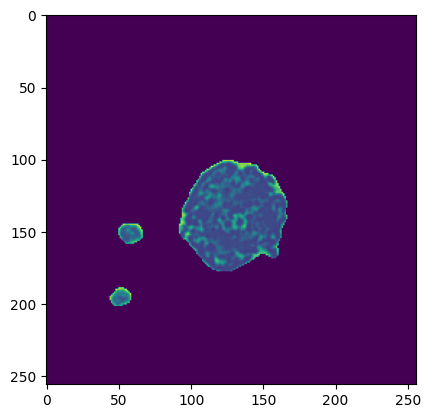

In [ ]:
import matplotlib.pyplot as plt

im = tf.io.read_file('/content/fusion/basophil/ERB_452425_fusion.png')
### Dans le cas des masques, l'image est en noir et blanc, il n'y a donc qu'une valeur par pixel
im = tf.io.decode_png(im, channels=1)
tf.image.resize(im, size=(256,256))
plt.imshow(im)

### **6. Création du dataframe 'df_fusion' des images masquées et de leur label**





In [ ]:
# Si besoin pour éviter étape 5., Import des images masquées 
!unzip 'drive/MyDrive/Datascientest/Images_masquees_19082023.zip'

In [ ]:
### Import des modules nécessaires pour l'ensemble du travail

import numpy as np
import os
import glob
import cv2
from keras import callbacks
import pandas as pd
import skimage.io as io
import skimage.transform as trans
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from keras.models import *
from keras.layers import *
from keras.optimizers import *
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras import backend as keras
from keras.applications import VGG16
from keras.layers import Multiply, Flatten, Dense, Input
from keras.models import Model
from keras.layers import BatchNormalization, Dropout
from tensorflow.keras.utils import plot_model

In [ ]:
# Trouver tous les chemins vers les fichiers qui finissent par .png
liste_fusion = glob.glob('/content/fusion/*/*.png')

# # Création d'une liste comprenant les chemins d'accès aux images ainsi que le label de chaque image
liste_fusion = list(map(lambda x : [
    '/content/PBC_dataset_normal_DIB/'+x.split('/')[3]+'/'+ x.split('/')[4].split('_')[0]+'_'+x.split('/')[4].split('_')[1]+'.jpg',
    '/content/masques/'+x.split('/')[3]+'/'+ x.split('/')[4].split('_')[0]+'_'+x.split('/')[4].split('_')[1]+'_mask.png',
    x,
    x.split('/')[4].split('_')[0]],
    liste_fusion))

# Créer un DataFrame pandas
df_fusion = pd.DataFrame(liste_fusion, columns=['filepath','maskpath','fusionpath','nameLabel'])
df_fusion=df_fusion.replace(['SNE','BNE'],'NEUTROPHIL')
df_fusion=df_fusion.replace(['MY','MMY','PMY'],'IG')
df_fusion.sort_values('fusionpath')
df_fusion

,filepath,maskpath,fusionpath,nameLabel
0,/content/PBC_dataset_normal_DIB/basophil/BA_15...,/content/masques/basophil/BA_152650_mask.png,/content/fusion/basophil/BA_152650_fusion.png,BA
1,/content/PBC_dataset_normal_DIB/basophil/BA_21...,/content/masques/basophil/BA_214521_mask.png,/content/fusion/basophil/BA_214521_fusion.png,BA
2,/content/PBC_dataset_normal_DIB/basophil/BA_41...,/content/masques/basophil/BA_412870_mask.png,/content/fusion/basophil/BA_412870_fusion.png,BA
3,/content/PBC_dataset_normal_DIB/basophil/BA_40...,/content/masques/basophil/BA_407690_mask.png,/content/fusion/basophil/BA_407690_fusion.png,BA
4,/content/PBC_dataset_normal_DIB/basophil/BA_13...,/content/masques/basophil/BA_136062_mask.png,/content/fusion/basophil/BA_136062_fusion.png,BA
...,...,...,...,...
17087,/content/PBC_dataset_normal_DIB/erythroblast/E...,/content/masques/erythroblast/ERB_566185_mask.png,/content/fusion/erythroblast/ERB_566185_fusion...,ERB
17088,/content/PBC_dataset_normal_DIB/erythroblast/E...,/content/masques/erythroblast/ERB_431862_mask.png,/content/fusion/erythroblast/ERB_431862_fusion...,ERB
17089,/content/PBC_dataset_normal_DIB/erythroblast/E...,/content/masques/erythroblast/ERB_161814_mask.png,/content/fusion/erythroblast/ERB_161814_fusion...,ERB
17090,/content/PBC_dataset_normal_DIB/erythroblast/E...,/content/masques/erythroblast/ERB_372346_mask.png,/content/fusion/erythroblast/ERB_372346_fusion...,ERB


In [ ]:
# répartition du nombre d'images selon le label dans le dataframe df_mask
df_fusion.nameLabel.value_counts()

NEUTROPHIL    3329
EO            3117
IG            2895
PLATELET      2348
ERB           1551
MO            1420
BA            1218
LY            1214
Name: nameLabel, dtype: int64

# **4. Création et entrainement du modèle benchmarch sur les images masquées**

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split

### **4.1. Séparation du jeu de données**

In [ ]:
# Diviser le dataframe en ensembles d'entraînement, de validation et de test
train_df, test_df = train_test_split(df_fusion, test_size=0.2, random_state=42)
train_df, val_df = train_test_split(train_df, test_size=0.2, random_state=42)

### **4.2. création du générateur de données et chargement des données train, val et test**

In [ ]:

datagen_train = ImageDataGenerator(rescale = 1./255, validation_split = 0.2)
datagen_test = ImageDataGenerator(rescale = 1./255)

batch_size = 32
height  = 256
width = 256
color = 3

train_set = datagen_train.flow_from_dataframe(
    dataframe = train_df,
    directory=None,
    x_col='fusionpath',
    y_col='nameLabel',
    target_size=(height, width),
    color_mode='rgb',
    classes=None,
    class_mode='categorical',
    batch_size=batch_size,
    shuffle=True,
    subset = "training"
)

validation_set = datagen_train.flow_from_dataframe(
    dataframe = train_df,
    directory=None,
    x_col='fusionpath',
    y_col='nameLabel',
    target_size=(height, width),
    color_mode='rgb',
    classes=None,
    class_mode='categorical',
    batch_size=batch_size,
    shuffle=False,
    subset = "validation"
)

test_set = datagen_test.flow_from_dataframe(
    dataframe = test_df,
    directory=None,
    x_col='fusionpath',
    y_col='nameLabel',
    target_size=(height, width),
    color_mode = 'rgb',
    classes = None,   # utilise y_col
    class_mode = 'categorical',
    batch_size = batch_size,
    shuffle = False)



nb_img_train = train_set.samples
nb_img_val = validation_set.samples
nb_img_test = test_set.samples

label_map = train_set.class_indices

print("le dataframe train est composé de {} images appartenant à {} classes".format(nb_img_train, len(train_set.class_indices)))
print("le dataframe validation est composé de {} images appartenant à {} classes".format(nb_img_val, len(validation_set.class_indices)))
print("le dataframe validation est composé de {} images appartenant à {} classes".format(nb_img_test, len(test_set.class_indices)))

Found 8751 validated image filenames belonging to 8 classes.
Found 2187 validated image filenames belonging to 8 classes.
Found 3419 validated image filenames belonging to 8 classes.
le dataframe train est composé de 8751 images appartenant à 8 classes
le dataframe validation est composé de 2187 images appartenant à 8 classes
le dataframe validation est composé de 3419 images appartenant à 8 classes


### **4.3. Vérification du chargement des données**

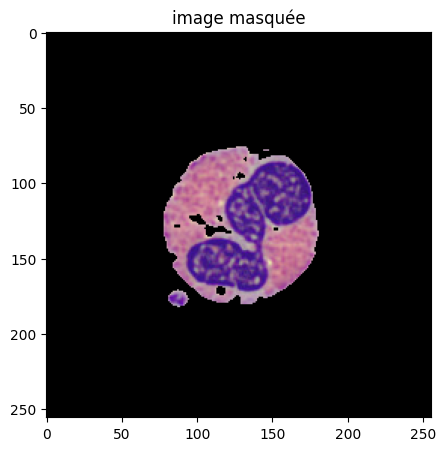

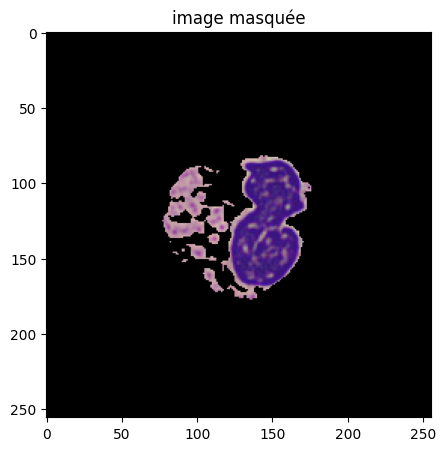

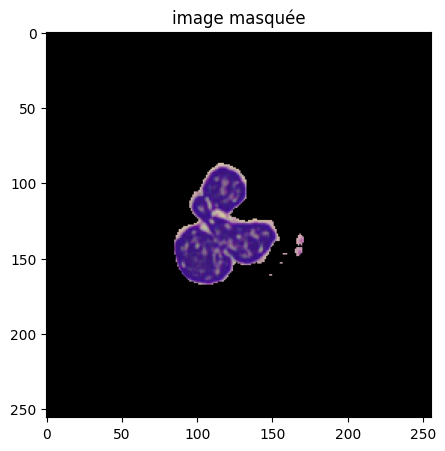

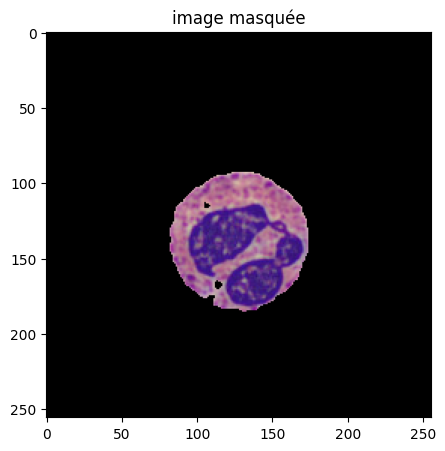

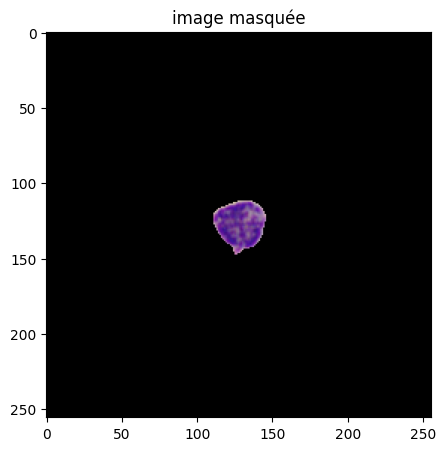

In [ ]:
import matplotlib.pyplot as plt


def visualize_sample(image):
    plt.figure(figsize=(10, 5))

    plt.imshow(image[0])
    plt.title("image masquée")

    plt.show()

# Prendre un échantillon du train_dataset
for idx, image in enumerate(train_set):
    if idx >= 5:  # Si vous avez déjà visualisé 5 images, arrêtez la boucle.
        break
    visualize_sample(image[0])

### **4.4. Création du modèle benchmark**

In [ ]:
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

### construction du modèle benchmark

num_classes = len(train_set.class_indices)

model_benchmark = Sequential([
  # layers.Rescaling(1./255, input_shape=(height, width, color)),
  layers.Conv2D(16, 3, padding='same', activation='relu',input_shape=(height, width, color)),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes, activation = 'softmax')
])

### **4.5. Compilation du modèle**

In [ ]:
#Compiler le modèle benchmark
model_benchmark.compile(optimizer='adam',
                        loss='categorical_crossentropy',
                        metrics=['accuracy'])
model_benchmark.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_9 (Conv2D)           (None, 256, 256, 16)      448       
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 128, 128, 16)     0         
 2D)                                                             
                                                                 
 conv2d_10 (Conv2D)          (None, 128, 128, 32)      4640      
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 64, 64, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_11 (Conv2D)          (None, 64, 64, 64)        18496     
                                                                 
 max_pooling2d_11 (MaxPoolin  (None, 32, 32, 64)      

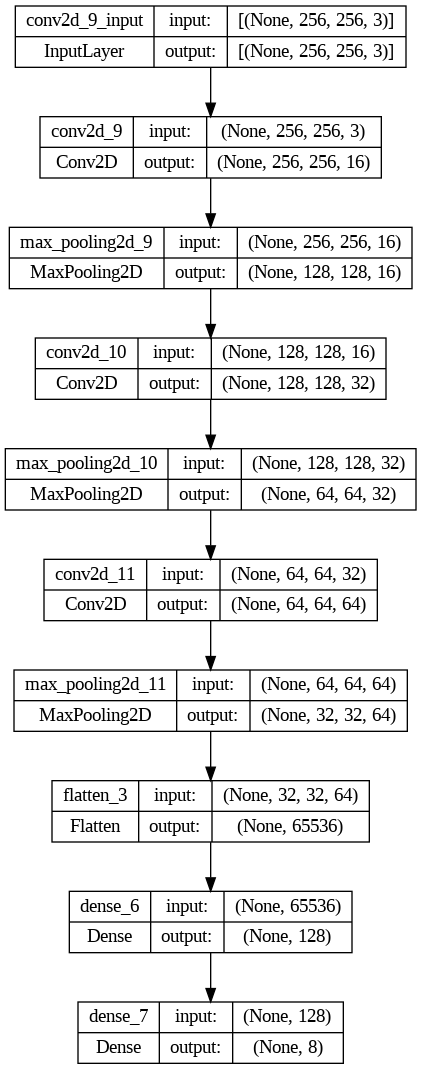

In [ ]:
# schéma du modèle Benchmark

plot_model(model_benchmark, show_shapes=True)

### **4.6. Définition des Callbacks**

In [ ]:
### Définition de callbacks

### Sauvegarde automatique des poids

checkpoint_Classification = callbacks.ModelCheckpoint(filepath = '/content/drive/MyDrive/weights_VGG16.h5',
                                       monitor = 'val_loss',
                                       save_best_only = True,
                                       save_weights_only = True,
                                       mode = 'min',
                                       save_freq = 'epoch')

### 'Callback' permettant d'ajuster le taux d'apprentissage au cours de l'entrainement
early_stopping = callbacks.EarlyStopping(monitor='val_loss', #métrique à controller
                                         min_delta = 0.01, # si au bout de 5 epochs la fonction de perte ne varie pas de 1%, que ce soit à la hausse ou à la baisse, on arrête au bout de 5 épochs
                                         patience=10,
                                         verbose = 0,
                                         mode='min',
                                         restore_best_weights=True)

lr_plateau = callbacks.ReduceLROnPlateau(monitor='val_loss', #métrique à controller
                                         factor=0.1, #factor by which the learning rate will be reduced. new_lr = lr * factor.
                                         patience=5, #number of epochs with no improvement after which learning rate will be reduced.
                                         verbose=0,
                                         mode='min')

### **4.7. Entraînement du modèle benchmark**

In [ ]:
### Entrainement model_benchmark

steps_per_epochs=nb_img_train//batch_size
validation_steps=nb_img_val//batch_size

Classification_model_benchmark=model_benchmark.fit(
                              train_set,
                              epochs=100,
                              steps_per_epoch=steps_per_epochs,
                              validation_data=validation_set,
                              validation_steps=validation_steps,
                              callbacks = [lr_plateau, early_stopping]
                              )

Epoch 1/100
273/273 [==============================] - 29s 87ms/step - loss: 0.7595 - accuracy: 0.7193 - val_loss: 0.4661 - val_accuracy: 0.8313 - lr: 0.0010
Epoch 2/100
273/273 [==============================] - 24s 86ms/step - loss: 0.3008 - accuracy: 0.8936 - val_loss: 0.3774 - val_accuracy: 0.8824 - lr: 0.0010
Epoch 3/100
273/273 [==============================] - 21s 76ms/step - loss: 0.1626 - accuracy: 0.9406 - val_loss: 0.3378 - val_accuracy: 0.8814 - lr: 0.0010
Epoch 4/100
273/273 [==============================] - 22s 82ms/step - loss: 0.0784 - accuracy: 0.9745 - val_loss: 0.3995 - val_accuracy: 0.8902 - lr: 0.0010
Epoch 5/100
273/273 [==============================] - 23s 85ms/step - loss: 0.0462 - accuracy: 0.9855 - val_loss: 0.4590 - val_accuracy: 0.8957 - lr: 0.0010
Epoch 6/100
273/273 [==============================] - 21s 78ms/step - loss: 0.0348 - accuracy: 0.9891 - val_loss: 0.5819 - val_accuracy: 0.8787 - lr: 0.0010
Epoch 7/100
273/273 [==============================]

### **4.8. Sauvegarde du modèle**

In [ ]:
#save model
model_benchmark.save('/content/drive/MyDrive/Datascientest/Blood_Cell_Project/model_benchmark_images_masquees.h5')

In [ ]:
#Chargement du modèle
model_benchmark = tf.keras.models.load_model('/content/drive/MyDrive/Datascientest/Blood_Cell_Project/model_benchmark_images_masquees.h5')
model_benchmark.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 256, 256, 3)       0         
                                                                 
 conv2d_1 (Conv2D)           (None, 256, 256, 16)      448       
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 128, 128, 16)     0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 128, 128, 32)      4640      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 64, 64, 32)       0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 64, 64, 64)        1

### **4.9. sauvegarde des performances du modèle**

In [ ]:
#sauvegarde des performances benchmark
train_acc_benchmark = Classification_model_benchmark.history['accuracy']
val_acc_benchmark = Classification_model_benchmark.history['val_accuracy']
train_loss_benchmark = Classification_model_benchmark.history['loss']
val_loss_benchmark = Classification_model_benchmark.history['val_loss']

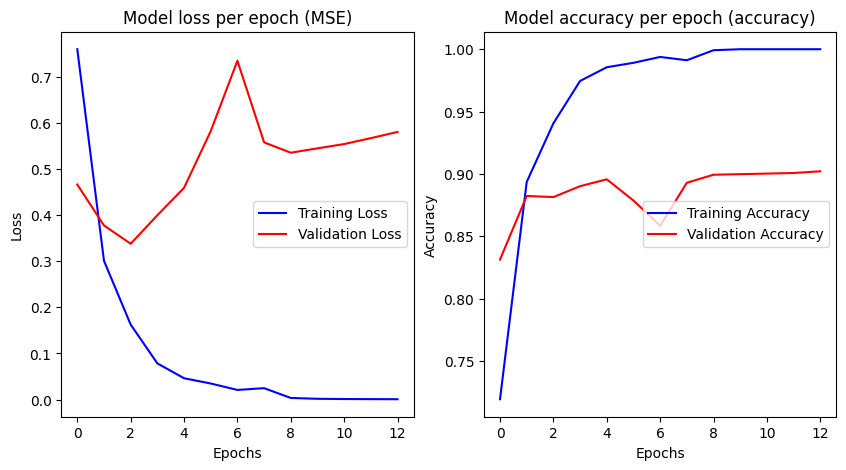

In [ ]:
import matplotlib.pyplot as plt

#visualisation des performances
plt.figure(figsize = (10, 5))

plt.subplot(121)
plt.plot(train_loss_benchmark, label = 'Training Loss', color = 'blue')
plt.plot(val_loss_benchmark, label = 'Validation Loss', color = 'red')
plt.title('Model loss per epoch (MSE)')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(loc='right')

plt.subplot(122)
plt.plot(train_acc_benchmark, label = 'Training Accuracy', color = 'blue')
plt.plot(val_acc_benchmark, label = 'Validation Accuracy', color = 'red')
plt.title('Model accuracy per epoch (accuracy)')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(loc='right')

plt.show()

### **4.10. Prédictions du modèle sur le jeu test**

In [ ]:
#Prediction
predictions_benchmark = model_benchmark.predict(test_set)
y_pred_benchmark = tf.argmax(predictions_benchmark, axis = 1)

107/107 [==============================] - 7s 67ms/step


### **4.11. Matrice de confusion**

In [ ]:
from sklearn.metrics import accuracy_score,classification_report, recall_score,confusion_matrix, roc_auc_score, precision_score, f1_score, roc_curve, auc, ConfusionMatrixDisplay, classification_report

#Création d'une Matrice de confusion
def plot_matrix(y_true, y_pred, label):
  cm = confusion_matrix(y_true.classes, y_pred)
  disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label)
  print('Vous retrouverez la matrice de confusion du modèle ci-dessous:')
  plt.figure()
  disp.plot(cmap=plt.cm.Blues)
  plt.show()

  print('\nVous retrouverez le rapport de classification du modèle ci-dessous:\n')
  print(classification_report(y_true.classes, y_pred, target_names=label))

Vous retrouverez la matrice de confusion du modèle ci-dessous:


<Figure size 640x480 with 0 Axes>

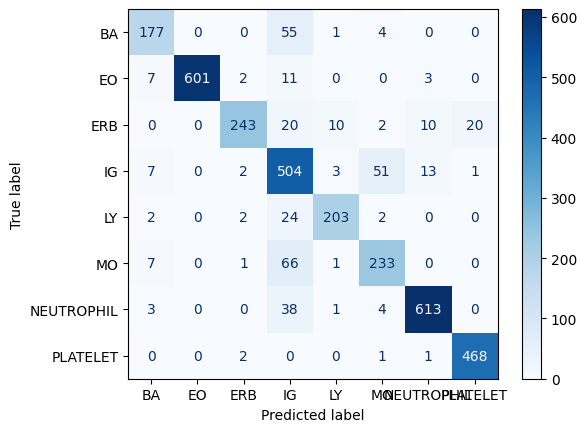


Vous retrouverez le rapport de classification du modèle ci-dessous:

              precision    recall  f1-score   support

          BA       0.87      0.75      0.80       237
          EO       1.00      0.96      0.98       624
         ERB       0.96      0.80      0.87       305
          IG       0.70      0.87      0.78       581
          LY       0.93      0.87      0.90       233
          MO       0.78      0.76      0.77       308
  NEUTROPHIL       0.96      0.93      0.94       659
    PLATELET       0.96      0.99      0.97       472

    accuracy                           0.89      3419
   macro avg       0.90      0.87      0.88      3419
weighted avg       0.90      0.89      0.89      3419



In [ ]:
plot_matrix(y_true = test_set, y_pred = y_pred_benchmark,label =label_map)

### **4.12. Enregistrement des performances du modèle dans un dataframe 'resultat_df'**

In [ ]:
label_map

{'BA': 0,
 'EO': 1,
 'ERB': 2,
 'IG': 3,
 'LY': 4,
 'MO': 5,
 'NEUTROPHIL': 6,
 'PLATELET': 7}

In [ ]:
columns = ['Model Name','Number of Params','Accuracy','Recall','Precision','F1_score']
resultat_df = pd.DataFrame(columns = columns)
resultat_df

,Model Name,Number of Params,Accuracy,Recall,Precision,F1_score


In [ ]:
def ajout_dataframe(nom_model, y_true, y_pred, num_params, dataframe):
  accuracy= []
  recall =[]
  precision = []
  f1 = []

  model_names = nom_model
  accuracy.append(round(accuracy_score(y_true.classes, y_pred),4))
  recall.append(round(recall_score(y_true.classes, y_pred, average='macro'),4))
  precision.append(round(precision_score(y_true.classes, y_pred, average='macro'),4))
  f1.append(round(f1_score(y_true.classes, y_pred, average='macro'),4))

  result_model = {'Model Name': model_names,'Number of Params': num_params,'Accuracy':accuracy,'Recall':recall, 'Precision':precision, 'F1_score': f1}
  dataframe = dataframe.append(result_model, ignore_index=True)
  return dataframe

In [ ]:
ajout_dataframe(nom_model = 'model_benchmark', y_true = test_set, y_pred = y_pred_benchmark, num_params = 16613544, dataframe = resultat_df)


,Model Name,Number of Params,Accuracy,Recall,Precision,F1_score
0,model_benchmark,16613544,[0.8897],[0.8655],[0.8956],[0.8776]


# **5. Interprétablité du modèle benchmark sur les images masquées**

In [ ]:
!pip install lime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 4.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283835 sha256=d5b84fc759610fadc0086fe1090b0d00055403652fca85af6f0b30d6ccfd268e
  Stored in directory: /root/.cache/pip/wheels/fd/a2/af/9ac0a1a85a27f314a06b39e1f492bee1547d52549a4606ed89
Successfully built lime


In [ ]:
#création d'un dataframe pour l'interprétabilité
mapping_dict = {value: key for key, value in label_map.items()}
df_interpretation = test_df.copy()

#Prediction
predictions_benchmark = model_benchmark.predict(test_set)
y_pred_benchmark = tf.argmax(predictions_benchmark, axis = 1)

#conversion
arr = np.array(y_pred_benchmark)
converted_arr = np.vectorize(mapping_dict.get)(arr)
df_interpretation['prediction'] = converted_arr
df_interpretation.head(10)

,filepath,maskpath,fusionpath,nameLabel,label_numerique,label_onehot,prediction
5293,/content/PBC_dataset_normal_DIB/neutrophil/BNE...,/content/masques/neutrophil/BNE_8741_mask.png,/content/fusion/neutrophil/BNE_8741_fusion.png,NEUTROPHIL,6,"[0, 0, 0, 0, 0, 0, 1, 0]",NEUTROPHIL
10421,/content/PBC_dataset_normal_DIB/eosinophil/EO_...,/content/masques/eosinophil/EO_339625_mask.png,/content/fusion/eosinophil/EO_339625_fusion.png,EO,1,"[0, 1, 0, 0, 0, 0, 0, 0]",EO
14126,/content/PBC_dataset_normal_DIB/platelet/PLATE...,/content/masques/platelet/PLATELET_368828_mask...,/content/fusion/platelet/PLATELET_368828_fusio...,PLATELET,7,"[0, 0, 0, 0, 0, 0, 0, 1]",PLATELET
16938,/content/PBC_dataset_normal_DIB/erythroblast/E...,/content/masques/erythroblast/ERB_452425_mask.png,/content/fusion/erythroblast/ERB_452425_fusion...,ERB,2,"[0, 0, 1, 0, 0, 0, 0, 0]",ERB
7180,/content/PBC_dataset_normal_DIB/neutrophil/BNE...,/content/masques/neutrophil/BNE_642218_mask.png,/content/fusion/neutrophil/BNE_642218_fusion.png,NEUTROPHIL,6,"[0, 0, 0, 0, 0, 0, 1, 0]",NEUTROPHIL
16012,/content/PBC_dataset_normal_DIB/erythroblast/E...,/content/masques/erythroblast/ERB_156600_mask.png,/content/fusion/erythroblast/ERB_156600_fusion...,ERB,2,"[0, 0, 1, 0, 0, 0, 0, 0]",ERB
8957,/content/PBC_dataset_normal_DIB/eosinophil/EO_...,/content/masques/eosinophil/EO_811522_mask.png,/content/fusion/eosinophil/EO_811522_fusion.png,EO,1,"[0, 1, 0, 0, 0, 0, 0, 0]",EO
12397,/content/PBC_dataset_normal_DIB/lymphocyte/LY_...,/content/masques/lymphocyte/LY_939287_mask.png,/content/fusion/lymphocyte/LY_939287_fusion.png,LY,4,"[0, 0, 0, 0, 1, 0, 0, 0]",LY
980,/content/PBC_dataset_normal_DIB/basophil/BA_80...,/content/masques/basophil/BA_803923_mask.png,/content/fusion/basophil/BA_803923_fusion.png,BA,0,"[1, 0, 0, 0, 0, 0, 0, 0]",BA
16888,/content/PBC_dataset_normal_DIB/erythroblast/E...,/content/masques/erythroblast/ERB_66535_mask.png,/content/fusion/erythroblast/ERB_66535_fusion.png,ERB,2,"[0, 0, 1, 0, 0, 0, 0, 0]",ERB


In [ ]:
import warnings

# Ignore all warnings
warnings.filterwarnings("ignore")

def create_dict_explainer(df, model):
  from lime.lime_image import LimeImageExplainer

  category = list(df.nameLabel.unique()) #je renseigne les différentes catégories
  n = 2
  height  = 256
  width = 256
  dict_explainer = {}

  for i in category:
    df_new = df.loc[df['nameLabel'] == i] #je crée un dataframe reprenant uniquement la catégorie i
    df_new = df_new.loc[df_new['nameLabel'] == df_new['prediction']] #je loc sur target = image
    df_new = df_new.sample(n=3) #je choisi 3 images aléatoires

    for j in range(n):
      image_path = df_new.iloc[j].fusionpath
      img = tf.keras.utils.load_img(image_path, target_size=(height, width))
      numpy_image = np.array(img)
      numpy_image = numpy_image / 255

      explainer = LimeImageExplainer(verbose = False)
      explanation = explainer.explain_instance(image = numpy_image,
                                         classifier_fn = model.predict,
                                         top_labels = 1,
                                         num_samples = 1000)
      # Store the object in the dictionary with a dynamic key
      key = f"explanation_{i}_{j}"
      dict_explainer[key] = explanation

  return dict_explainer

In [ ]:
%%capture
dict_explainer_benchmark = create_dict_explainer(df_interpretation, model_benchmark)

In [ ]:
def plot_explainer(dict_explainer):
  from skimage.segmentation import mark_boundaries
  for cle, objet in dict_explainer.items():
    print("Analyse LIME pour l'image {}".format(cle))
    temp_1, mask_1 = objet.get_image_and_mask(objet.top_labels[0], positive_only=True, num_features=5, hide_rest=True)
    temp_2, mask_2 = objet.get_image_and_mask(objet.top_labels[0], positive_only=False, num_features=10, hide_rest=False)
    plt.figure(figsize=(10,10))
    plt.subplot(121)
    plt.imshow(mark_boundaries(temp_1, mask_1))
    plt.title('SuperPixel pour cette catégorie')
    plt.axis('off')

    plt.subplot(122)
    plt.imshow(mark_boundaries(temp_2, mask_2))
    plt.title('Répartition des pixels positifs (vert) et négatifs (rouge)')
    plt.axis('off')
    plt.show()

Analyse LIME pour l'image explanation_NEUTROPHIL_0


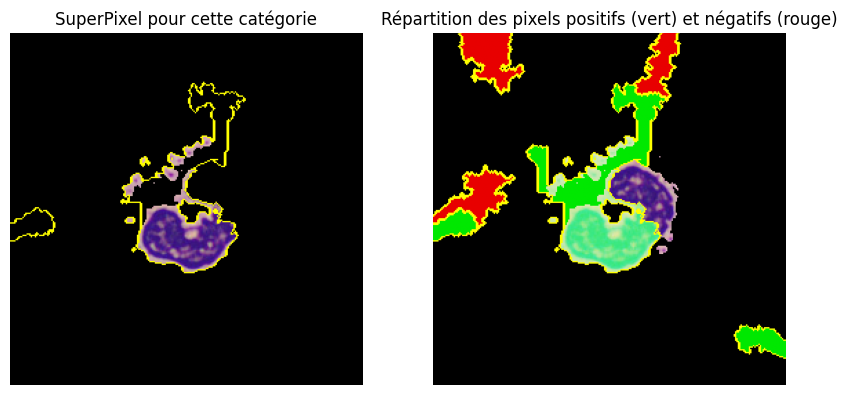

Analyse LIME pour l'image explanation_NEUTROPHIL_1


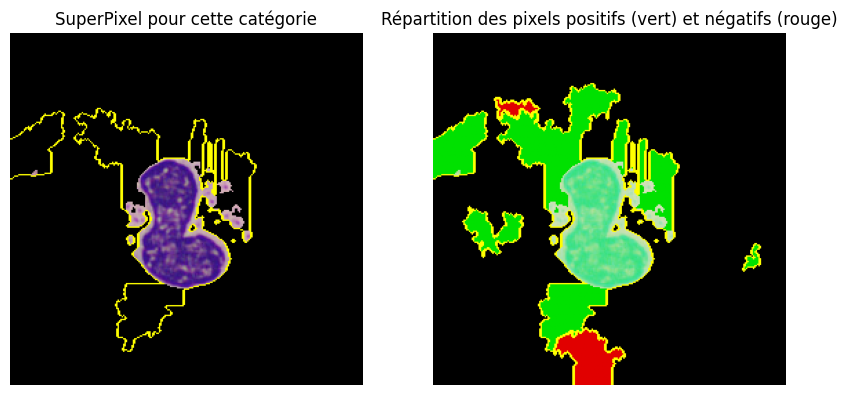

Analyse LIME pour l'image explanation_EO_0


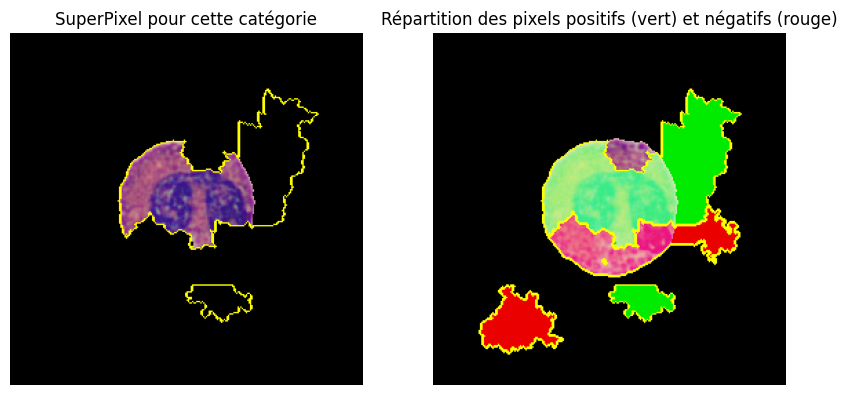

Analyse LIME pour l'image explanation_EO_1


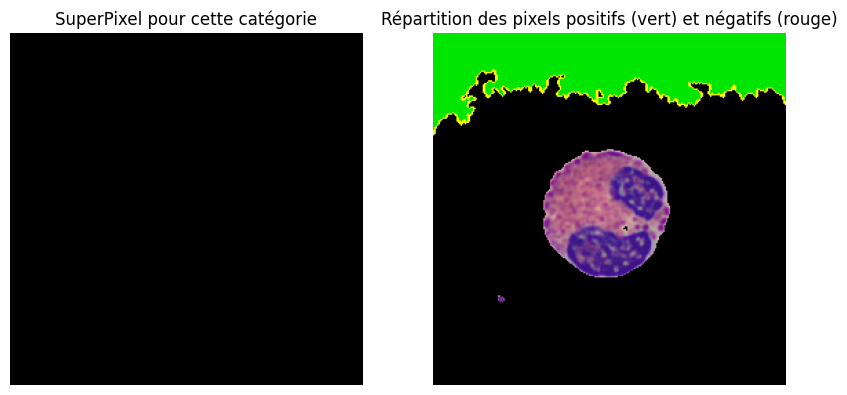

Analyse LIME pour l'image explanation_PLATELET_0


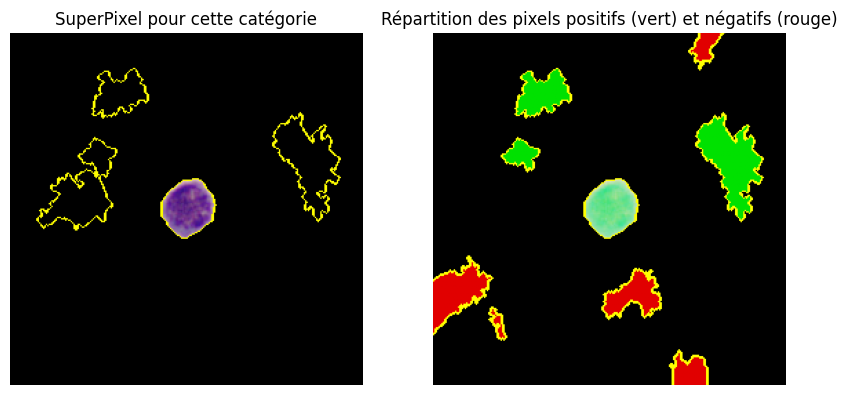

Analyse LIME pour l'image explanation_PLATELET_1


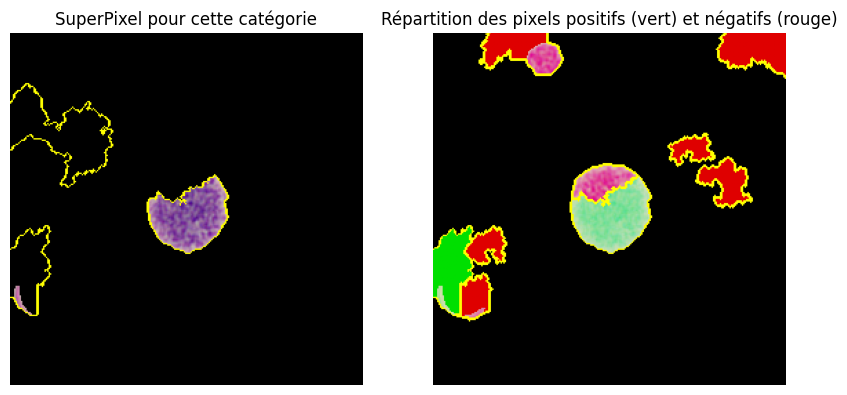

Analyse LIME pour l'image explanation_ERB_0


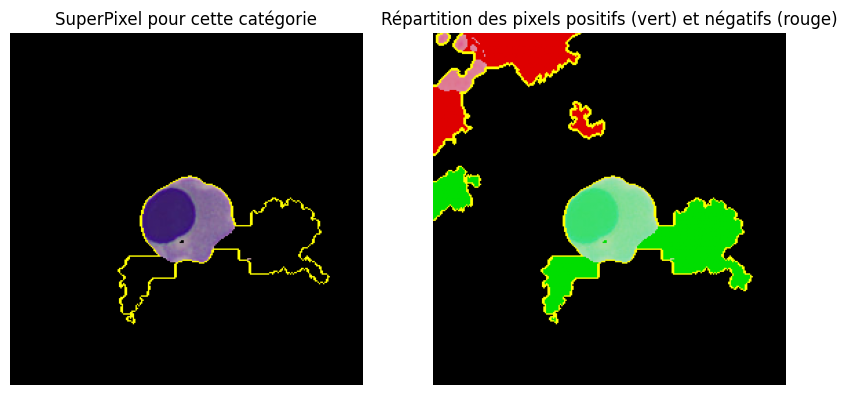

Analyse LIME pour l'image explanation_ERB_1


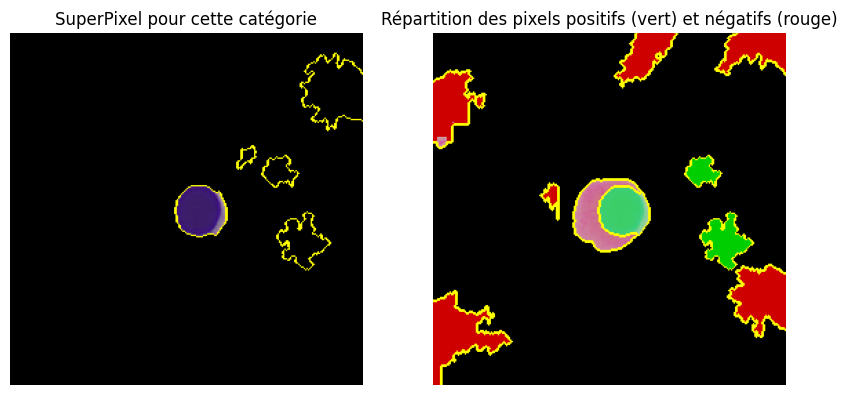

Analyse LIME pour l'image explanation_LY_0


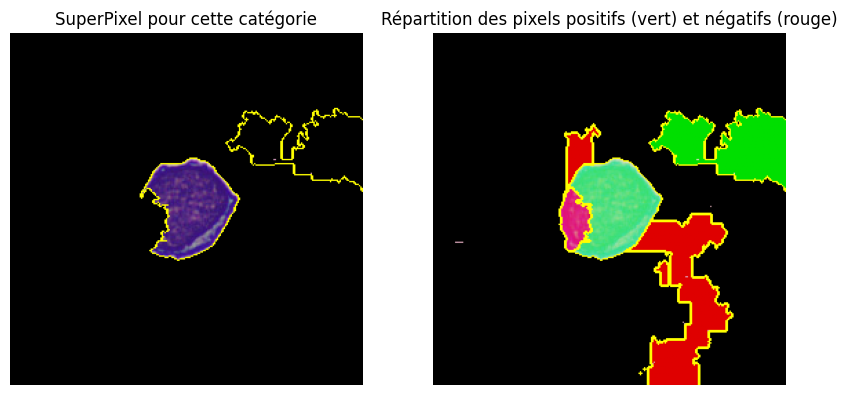

Analyse LIME pour l'image explanation_LY_1


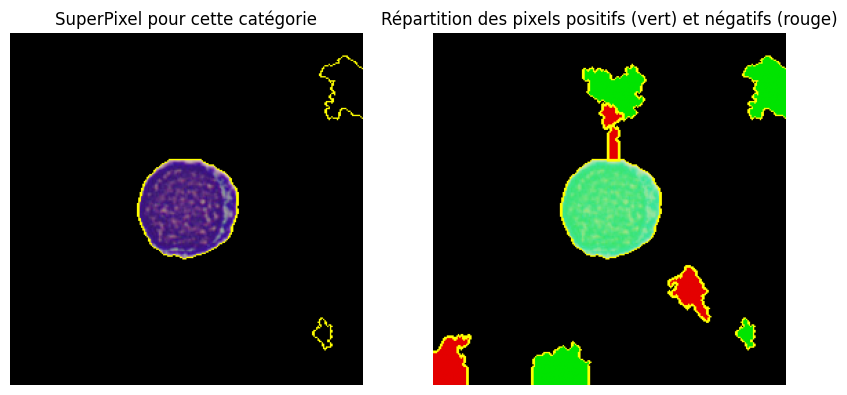

Analyse LIME pour l'image explanation_BA_0


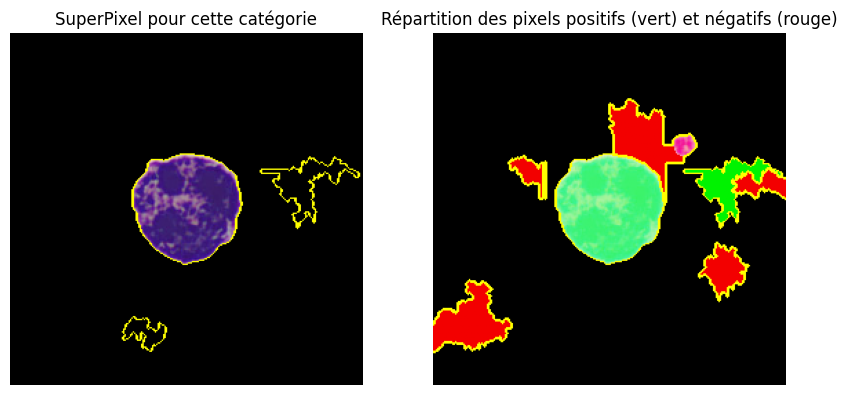

Analyse LIME pour l'image explanation_BA_1


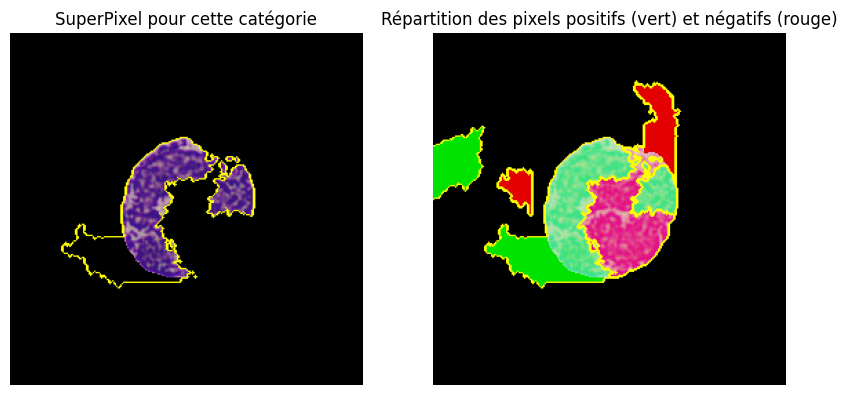

Analyse LIME pour l'image explanation_IG_0


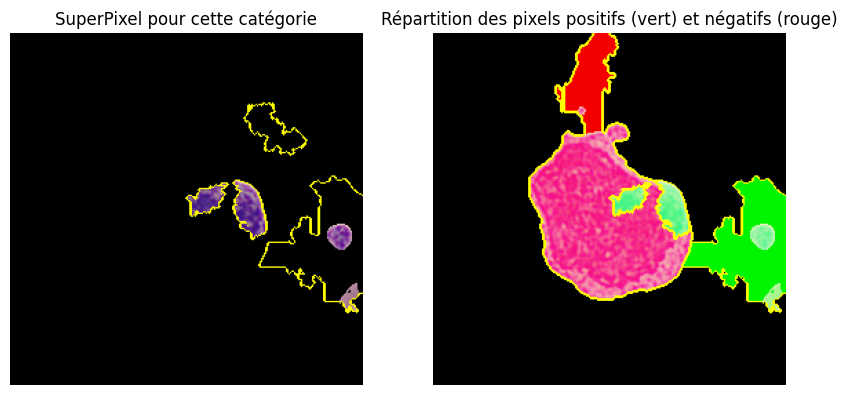

Analyse LIME pour l'image explanation_IG_1


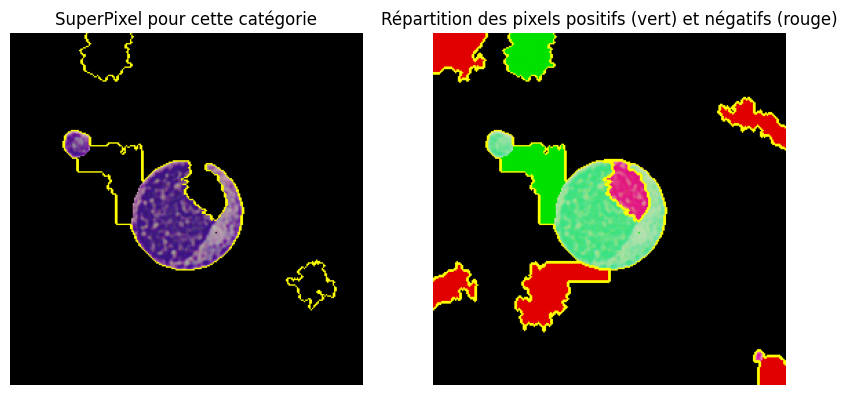

Analyse LIME pour l'image explanation_MO_0


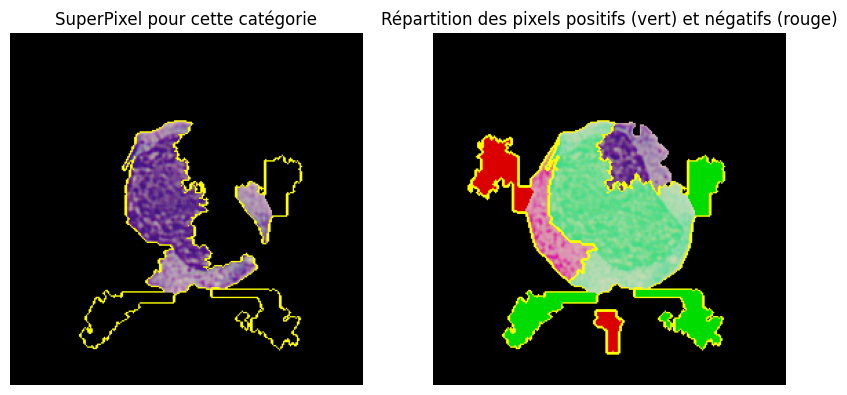

Analyse LIME pour l'image explanation_MO_1


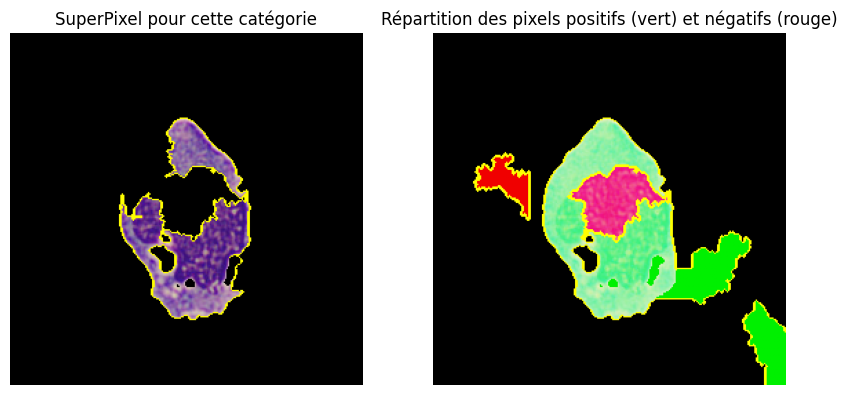

In [ ]:

plot_explainer(dict_explainer_benchmark)